# Using Linear Regression to Predict House Sale Prices
---
Written by Neil Mackenzie

# Introduction
This guided project was completed following a Linear Regression [course](https://www.dataquest.io/course/linear-algebra-for-machine-learning/) on Dataquest.io

The aim of this project is to practice the implementation of linear regresion to predict the price of houses in Ames, Iowa, United States.

The original paper written by Dean De Cock presenting this dataset can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). The xls version of the dataset can be downloaded directly from [this](http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls) link and information about the columns of the dataset can be found on [this](https://s3.amazonaws.com/dq-content/307/data_description.txt) page. Note the xls file was saved as a csv file for this project

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from IPython.display import display, HTML

#Set options for displaying dataframes using display()
pd.options.display.max_columns = 999
pd.options.display.max_rows = 10

#Read dataset
housing_data = pd.read_csv('AmesHousing.csv', encoding = 'utf-8')
#Preview first 5 rows of dataset
housing_data.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Data Cleaning & Feature Engineering
The feature columns will be updated in the cells below to handle missing values, transform text and numerical columns and create new columns that reveal valuable information about each house.

The strategies for cleaning the dataset and creating new columns are tested below before being implemented into new functions that will carry execute the operations. The operations are outlined below and tested in the cells that follow.
1. Drop missing data
2. Drop columns containing information that is not valuable to an ML model
3. Feature engineering to identify and generate useful information
4. Drop columns that are no longer required or leak information about the final sale since this would "cheat" the model

# Test operations
---
The strategies for cleaning the dataset are tested below before being implemented into an ML model. The four steps used to clean and prepare the dataset are:
1. Drop missing data
2. Drop columns that will not be useful for an ML model
3. Feature engineering to derive new columns that reveal valuable information
4. Drop columns that leak/reveal information about the sale price of the house since this information will bias the ML model

## 1.  Drop missing data

Missing data will be handled differently depending on the amount of data missing in the column and the type of data stored in the column. The strategy for cleaning columns is described below:
1. All columns
    - Drop column if > 5% of data in column is missing
2. Numerical columns 
    - Columns containing less than 5% missing data will have missing information filled with the mode of that column
3. Text columns
    - Drop columns with any missing information

In [2]:
#Preview current dataframe to allow confirmation that data is being dropped
display(housing_data)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,

In [3]:
#1: Drop columns if > 5% data missing
def drop_missing(df):
    #Count number of missing values in each column
    missing_data = df.isnull().sum()
    
    #5% cutoff length
    cut_off = len(df)*0.05
    
    #Create df with columns containing <5% missing data
    dropped_cols = df.drop(missing_data[missing_data > cut_off].index, axis = 1)
    
    #Return cleaned df
    return dropped_cols

missing_dropped = drop_missing(housing_data)

#Display updated dataset to check number of cols
display(missing_dropped)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,2.0,588.0,Y,120,0,0,0,0,0,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,2.0,484.0,Y,164,0,0,0,0,0,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1974,1975,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,1071.0,LwQ,123.0,195.0,1389.0,GasA,Gd,Y,SBrkr,1389,0,0,1389,1.0,0.0,1,0,2,1,TA,6,Typ,1,2.0,418.0,Y,240,38,0,0,0,0,0,4,2006,WD,Normal,170000


The number of columns has reduced from 82 to 71 so the first step has worked

In [4]:
#2: Fill missing values for numerical columns if < 5% data missing
#Note all columns with >5% missing have already been removed above
def fill_na(df):
    #Identify numerical columns
    numeric_cols = df.select_dtypes(include = np.number)
   
    #Count missing values in each col and identify columns to fix
    count_missing = numeric_cols.isnull().sum()
    to_fix = count_missing[count_missing > 0]

    #Dictionary of modes for numerical columns that have na values    
    replacements = df[to_fix.index].mode().to_dict(orient = 'records')[0]
    
    dropped_na = df.fillna(replacements)
    
    return dropped_na

missing_numeric = missing_dropped.select_dtypes(include = ['int', 'float']).isnull().sum()
missing_numericals = missing_numeric[missing_numeric > 0]
print("Before removing null values:")
print(missing_numericals)

fixed_numeric = fill_na(missing_dropped)
fixed_numbers = fixed_numeric.select_dtypes(include = ['int', 'float']).isnull().sum()
fixed_numericals = fixed_numbers[fixed_numbers > 0]
print("\nAfter removing null values:")
print(fixed_numericals)

Before removing null values:
Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

After removing null values:
Series([], dtype: int64)


No numerical columns contain missing data after running the above function. We can now proceed to #3 of the process outlined above

In [5]:
#3: Drop columns with missing text data
def drop_text(df):
    count_text_data = df.select_dtypes(include = ['object']).isnull().sum()
    count_text_data.head(10)
    
    missing_text = count_text_data[count_text_data > 0]
    missing_text_index = missing_text.index
    missing_text_dropped = df.drop(missing_text_index, axis = 1)
    
    return missing_text, missing_text_dropped
        
dropped_cols, cleaned_df = drop_text(fixed_numeric)
print("Columns that were dropped due to missing text information:\n",dropped_cols)
print("=================================================")
print("Cleaned dataframe:")
display(cleaned_df)

Columns that were dropped due to missing text information:
 Mas Vnr Type      23
Bsmt Qual         80
Bsmt Cond         80
Bsmt Exposure     83
BsmtFin Type 1    80
BsmtFin Type 2    81
Electrical         1
dtype: int64
Cleaned dataframe:


,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,819.0,0.0,184.0,1003.0,GasA,TA,Y,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,2.0,588.0,Y,120,0,0,0,0,0,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,301.0,324.0,239.0,864.0,GasA,TA,Y,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,2.0,484.0,Y,164,0,0,0,0,0,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,0.0,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1974,1975,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,1071.0,123.0,195.0,1389.0,GasA,Gd,Y,1389,0,0,1389,1.0,0.0,1,0,2,1,TA,6,Typ,1,2.0,418.0,Y,240,38,0,0,0,0,0,4,2006,WD,Normal,170000


The dataframe has been reduced from 71 to 64 columns by removing text columns with missing data. The columns that were dropped are listed above.

## 2. Drop columns that aren't useful for ML model

After reviewing the [columns](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) contained in the dataset, it is clear that some columns will not add any value to the ML model. These columns are listed below and removed in the following cell.


Column|Description
---|---
Order|Observation Number
PID|Parcel Identification Number

In [6]:
non_ml_cols = ['Order','PID']
non_ml_removed = cleaned_df.drop(non_ml_cols, axis = 1)

#print preview of df to confirm columns were dropped. Number of cols should be 2 less than df above
display(non_ml_removed)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,819.0,0.0,184.0,1003.0,GasA,TA,Y,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,2.0,588.0,Y,120,0,0,0,0,0,0,3,2006,WD,Normal,142500
2926,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,301.0,324.0,239.0,864.0,GasA,TA,Y,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,2.0,484.0,Y,164,0,0,0,0,0,0,6,2006,WD,Normal,131000
2927,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,0.0,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal,132000
2928,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1974,1975,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,1071.0,123.0,195.0,1389.0,GasA,Gd,Y,1389,0,0,1389,1.0,0.0,1,0,2,1,TA,6,Typ,1,2.0,418.0,Y,240,38,0,0,0,0,0,4,2006,WD,Normal,170000


## 3. Feature engineering
New columns will now be created to quickly identify some information about the houses which is not immediately clear in the dataset. This includes identifying how old the house was when it was sold and how many years passed after the house was renovated before it was sold.

In [7]:
#Create new columns
non_ml_removed['Age At Sale'] = non_ml_removed['Yr Sold'] - non_ml_removed['Year Built']
non_ml_removed['Yrs Between Remod & Sale'] = non_ml_removed['Yr Sold'] - non_ml_removed['Year Remod/Add']

#Check for values less than 0 in new columns (these represent errors):
display(non_ml_removed[non_ml_removed['Age At Sale'] < 0])
display(non_ml_removed[non_ml_removed['Yrs Between Remod & Sale'] < 0])


,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Age At Sale,Yrs Between Remod & Sale
2180,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2


,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Age At Sale,Yrs Between Remod & Sale
1702,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,0.0,Gd,TA,PConc,0.0,0.0,1582.0,1582.0,GasA,Ex,Y,1582,570,0,2152,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,728.0,Y,0,368,0,0,0,0,0,6,2007,New,Partial,260116,0,-1
2180,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,762.0,Ex,TA,PConc,2260.0,0.0,878.0,3138.0,GasA,Ex,Y,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,3.0,884.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750,0,-1


The rows shown above have some sort of error since the house could not have been sold before it was built or renovated. These rows will therefore be dropped from the dataset.

In [8]:
cleaned_non_ml_removed = non_ml_removed.drop([1702, 2180, 2181])

## 4. Drop columns that leak final price information
Columns that may leak information were also determined by reviewing the columns of the dataset on the same webpage listed above. These columns are removed below.


In [9]:
drop_leak_cols = ['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold']
leaked_dropped = cleaned_non_ml_removed.drop(drop_leak_cols, axis = 1)

display(leaked_dropped)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Age At Sale,Yrs Between Remod & Sale
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,189900,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,819.0,0.0,184.0,1003.0,GasA,TA,Y,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,2.0,588.0,Y,120,0,0,0,0,0,0,142500,22,22
2926,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,301.0,324.0,239.0,864.0,GasA,TA,Y,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,2.0,484.0,Y,164,0,0,0,0,0,0,131000,23,23
2927,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,0.0,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,132000,14,14
2928,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1974,1975,Gable,CompShg,HdBoard,HdBoard,0.0,TA,TA,CBlock,1071.0,123.0,195.0,1389.0,GasA,Gd,Y,1389,0,0,1389,1.0,0.0,1,0,2,1,TA,6,Typ,1,2.0,418.0,Y,240,38,0,0,0,0,0,170000,32,31


# Linear Regression Model Development
The data cleaning and feature engineering strategy was determined above and can now be implemented into functions that execute all of the operationstested above. The dataset will then be split into test and training sets which will be used to train a linear regression model.

In [10]:
#Define transform_features() to execture cleaning operations 1 to 4 from above
def transform_features(df):
    
    #Create df with <5% missing values in each column
    missing_data = df.isnull().sum()
    df = df.drop(missing_data[missing_data > len(df)*0.05].index, axis = 1)
    
    #Fill missing values for numerical columns
    num_missing = df.select_dtypes(include = np.number).isnull().sum()
    num_to_fix = num_missing[num_missing > 0]
    replacements = df[num_to_fix.index].mode().to_dict(orient = 'records')[0]
    df = df.fillna(replacements)
    
    #Remove text columns if any values missing
    count_text_data = df.select_dtypes(include = ['object']).isnull().sum()    
    missing_text = count_text_data[count_text_data > 0]
    df = df.drop(missing_text.index, axis = 1)
    
    #Create new columns
    df['Age At Sale'] = df['Yr Sold'] - df['Year Built']
    df['Yrs Between Remod & Sale'] = df['Yr Sold'] - df['Year Remod/Add']
    
    
    #Drop non-ml and columns and columns that leak price info
    drop_cols = ['Order','PID','Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold']
    df = df.drop(drop_cols, axis = 1)
    
    #Drop columns that were found to have false values after feature engineering
    df = df.drop([1702, 2180, 2181])
    
    #Return cleaned and engineered dataset
    return df


In [11]:
#Function to extract training set
def get_datasets(df,length):
    #Create new train and test dataframes to keep original df in tact
    train = df.iloc[0:length]
    test = df.iloc[length:]
    return train, test

#Function to select features for training
#This is just a placeholder at this stage. To be developed in next section
def select_features(df, columns):
    return df[columns]

In [12]:
#Function to train and test a LR model
def train_and_test(df):
    #Length of training dataset
    training_length = 1460
    #Isolate training and testing datasets
    train, test = get_datasets(df,training_length)
    
    #Numericalcolumns to use for training model
    numeric_train = train.select_dtypes(include = np.number)
    train_features = numeric_train.columns.drop('SalePrice')
    numeric_test = test.select_dtypes(include = np.number)
    test_features = numeric_test.columns.drop('SalePrice')
    
    #Dataframes of taining, target and test data
    train_data = select_features(train,train_features)
    train_target = select_features(train,['SalePrice'])
    test_data = select_features(test,test_features)

    #Fit linear regression model
    lr = LinearRegression()
    lr.fit(train_data,train_target)
    #Predict target column using model trained on selected columns
    predictions = lr.predict(test_data)
    
    #Calculate mse and rmse
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse
    
#Clean and transform columns in dataset    
transformed_df = transform_features(housing_data)

#Get RMSE value for cleaned dataset using all columns to predict value
rmse = train_and_test(transformed_df)
print(rmse)

71217.05359382681


Now that the dataset has been cleaned and transformed and a model has been made to determined the RMSE value for a given set of columns, its time to move on to feature selection. This will identify the best columns to use for predicting the sale price and will be done in two steps which are described below

1. The correlation between each numerical column and the target column (SalePrice) will be assessed with a correlation matrix.
2. Columns that should be encoded as categorical will be converted into the correct type using [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29)

# Feature Selection
---
## 1. Correlation
The correlation between each feature and the target column is assessed below

In [13]:
#Specify target values
target = transformed_df['SalePrice']

#Extract only numerical columns
numerical_cols = transformed_df.select_dtypes(include = [np.number])

#Check correlation of each feature with SalePrice column
correlation_mat = numerical_cols.corr()['SalePrice'].sort_values()

#print correlation matrix
with pd.option_context('display.max_rows', 40):
    display(correlation_mat)

Age At Sale                -0.558979
Yrs Between Remod & Sale   -0.534985
Enclosed Porch             -0.128685
Kitchen AbvGr              -0.119760
Overall Cond               -0.101540
MS SubClass                -0.085128
Low Qual Fin SF            -0.037629
Bsmt Half Bath             -0.035875
Misc Val                   -0.019273
BsmtFin SF 2                0.006127
3Ssn Porch                  0.032268
Pool Area                   0.068438
Screen Porch                0.112280
Bedroom AbvGr               0.143916
Bsmt Unf SF                 0.182751
Lot Area                    0.267520
2nd Flr SF                  0.269601
Bsmt Full Bath              0.276258
Half Bath                   0.284871
Open Porch SF               0.316262
Wood Deck SF                0.328183
BsmtFin SF 1                0.439284
Fireplaces                  0.474831
TotRms AbvGrd               0.498574
Mas Vnr Area                0.506983
Year Remod/Add              0.533007
Full Bath                   0.546118
Y

Negative values in the cell above indicate a negative correlation with sale price. This means that 'Age at Sale' has a strong negative correlation with the sale price. This makes intuitive sense since it would be expected that an older house would be sold for a lower price.

This information can be used to drop columns with correlation coefficients below a selected value.

## 2. Convert Categorical Columns
The features that should be categorical are identified and handled below

In [14]:
#Columns that should be categorical from original dataset:
all_cat_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
            "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
            "Exterior 2nd", "Exter Cond", "Exter Qual",  "Mas Vnr Type", "Foundation", "Functional", "Heating", 
                "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition", "Heating QC",
                "Kitchen Qual", "Land Slope", "Lot Shape", "Paved Drive", "Utilities"]

#Categorical columns that are still in cleaned, transformed dataset:
cat_cols = []
for col in all_cat_cols:
    if col in transformed_df.columns:
        cat_cols.append(col)

#Check categorical columns in dataset as determined above
cat_cols.sort()
print(cat_cols,'\n')

#Confirm categorical columns by comparing the list generated above with 'object' columns
text_cols = transformed_df.select_dtypes(include = ['object']).columns.tolist()
print(sorted(text_cols))

['Bldg Type', 'Central Air', 'Condition 1', 'Condition 2', 'Exter Cond', 'Exter Qual', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Functional', 'Heating', 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS SubClass', 'MS Zoning', 'Neighborhood', 'Paved Drive', 'Roof Matl', 'Roof Style', 'Street', 'Utilities'] 

['Bldg Type', 'Central Air', 'Condition 1', 'Condition 2', 'Exter Cond', 'Exter Qual', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Functional', 'Heating', 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour', 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Neighborhood', 'Paved Drive', 'Roof Matl', 'Roof Style', 'Street', 'Utilities']


The columns shown above should contain categorical values. The 'MS SubClass' column was not picked up in the test at the end of the cell block since this column contains numerical values that are used to categorize the type of dwelling involved. This column should therefore still be included as a 'category' column.

Dummy coding will now be used below to separate each of these columns into n binary columns where n is the number of unique values in the column. 

Doing this for all columns irrespective of the number of unique values could make a massive dataframe so lets first check the number of unique values in each of these columns. Dummy coding will be used for columns that contain fewer than 10 unique values. Columns with more than 10 unique values will be removed to avoid making the dataframe too large.

In [15]:
# Check for number of unique values in each categorical column
unique_vals = transformed_df[cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

# Extract index of categorical columns with less than 10 unique values and remove columns with over 10 unique vals
unique_under_10 = unique_vals[unique_vals < 10].index
unique_over_10 = unique_vals[unique_vals >= 10].index
reduced_df = transformed_df.drop(unique_over_10, axis = 1)

# Convert categorical columns to 'category' datatype for use with get_dummies function
cat_cols = transformed_df[unique_under_10].copy()
for col in cat_cols:
    cat_cols[col] = cat_cols[col].astype('category')

# Create df with numiercal columns and dummy columns in place of categorical columns
df_with_cats = pd.concat([transformed_df, pd.get_dummies(cat_cols)], axis = 1)
df_with_cats = df_with_cats.drop(unique_under_10, axis = 1)

The cut-off number of unique feature values was chosen as 10 in the example above but can be pre-defined to avoid the dataset becoming too large.

# Linear Regression Model
The linear regression model from the section above can now be updated to include the feature selection techniques tested above. The LR model from above is copy-pasted below with the changes incorporated into the select_features function. 

The parameter 'k' is also introducted to the train_and_test function for k-fold cross validation. This requires if statements to be added to the function which alter the behaviour depending on the value of k since k-fold cross validation does not work for k = 0 ([holdout validation](https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f)) or k = 1 (simple cross validation)

In [16]:
#Define transform_features() to execture cleaning operations 1 to 4 from above
def transform_features(df):
    
    #Create df with <5% missing values in each column
    missing_data = df.isnull().sum()
    df = df.drop(missing_data[missing_data > len(df)*0.05].index, axis = 1)
    
    #Fill missing values for numerical columns
    num_missing = df.select_dtypes(include = np.number).isnull().sum()
    num_to_fix = num_missing[num_missing > 0]
    replacements = df[num_to_fix.index].mode().to_dict(orient = 'records')[0]
    df = df.fillna(replacements)
    
    #Remove text columns if any values missing
    count_text_data = df.select_dtypes(include = ['object']).isnull().sum()    
    missing_text = count_text_data[count_text_data > 0]
    df = df.drop(missing_text.index, axis = 1)
    
    #Create new columns
    df['Age At Sale'] = df['Yr Sold'] - df['Year Built']
    df['Yrs Between Remod & Sale'] = df['Yr Sold'] - df['Year Remod/Add']
    
    
    #Drop non-ml and columns and columns that leak price info
    drop_cols = ['Order','PID','Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold']
    df = df.drop(drop_cols, axis = 1)
    
    #Drop columns that were found to have false values after feature engineering
    df = df.drop([1702, 2180, 2181])
    
    #Return cleaned and engineered dataset
    return df

In [17]:
#Function to extract training set
def get_datasets(df,length):
    #Create new train and test dataframes to keep original df in tact
    train = df.iloc[0:length]
    test = df.iloc[length:]
    return train, test

#Function to select features for training
def select_features(df, corr_cutoff, dummy_cutoff):

#Drop numerical features with correlation less than corr_cutoff
    target = df['SalePrice']

    #Extract only numerical columns
    numerical_cols = df.select_dtypes(include = [np.number])

    #Check correlation of each feature with SalePrice column
    corr_mat = numerical_cols.corr()['SalePrice'].sort_values()
    
    #Drop values with correlation lower than corr_cutoff
    df = df.drop(corr_mat[corr_mat < corr_cutoff].index, axis = 1)

#Convert categorical columns to dummy columns after dropping 
#those with more than dummy_cutoff unique values

    #Columns that should be categorical from original dataset:
    all_cat_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Exter Cond", "Exter Qual",  "Mas Vnr Type", "Foundation", "Functional", "Heating", 
                    "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition", "Heating QC",
                    "Kitchen Qual", "Land Slope", "Lot Shape", "Paved Drive", "Utilities"]

    #Categorical columns that are still in cleaned, transformed dataset:
    cat_cols = []
    for col in all_cat_cols:
        if col in df.columns:
            cat_cols.append(col)

    # Check for number of unique values in each categorical column
    unique_vals = df[cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

    # Extract index of categorical columns with less than dummy_cutoff unique values and 
    #remove columns with over dummy_cutoff unique vals
    unique_under_cutoff = unique_vals[unique_vals < dummy_cutoff].index
    unique_over_cutoff = unique_vals[unique_vals >= dummy_cutoff].index
    reduced_df = df.drop(unique_over_cutoff, axis = 1)

    # Convert categorical columns to 'category' datatype for use with get_dummies function
    cat_cols = transformed_df[unique_under_10].copy()
    for col in cat_cols:
        cat_cols[col] = cat_cols[col].astype('category')

    # Create df with numerical columns and dummy columns with original categorical columns removed    df_with_cats = pd.concat([transformed_df, pd.get_dummies(cat_cols)], axis = 1)
    df_final = df_with_cats.drop(unique_over_cutoff, axis = 1)

    return df_final

In [18]:
#Function to train and test a LR model. k = 0 by default
def train_and_test(df, k=0 ):
    #Isolate numeric features:
    numeric_features = df.select_dtypes(include = [np.number])
    features = numeric_features.columns.drop('SalePrice')
    lr = LinearRegression()

    #holdout validation
    if k == 0:
        #Length of training dataset
        training_length = 1460
        #Isolate training and testing datasets
        train, test = get_datasets(df,training_length)

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return predictions, rmse
    
    if k == 1:
         # Randomize all rows ie frac = 1
        shuffled_df = df.sample(frac = 1)
        #Length of training dataset
        training_length = 1460
        #Isolate training and testing datasets
        train, test = get_datasets(df,training_length)
        
        #First model - train on first half and test on second half
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        #Second model - train on second half and train on first half
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print("RMSE training on first half:",rmse_one)
        print("RMSE training on seconds half:",rmse_two)
        print("Average RMSE:", avg_rmse)
        return predictions_one, avg_rmse
    
    else:
        #Kfold cross validation using n splits
        #Use random_state argument for reproducible results
        kf = KFold(n_splits = k, shuffle = True, random_state = 3)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            #Length of training dataset
            training_length = 1460

            #Dataframes of taining, target and test data
            train_data = df.iloc[train_index]
            test_data = df.iloc[test_index]

            #Fit linear regression model
            lr = LinearRegression()
            lr.fit(train_data[features],train_data['SalePrice'])
            #Predict target column using model trained on selected columns
            predictions = lr.predict(test_data[features])

            #Calculate mse and rmse
            mse = mean_squared_error(test_data['SalePrice'], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            
        #Print actual vs predicted value
        print('Preview of actual prices vs predicted results')
        rounded = [elem.astype('int') for elem in predictions]
        data = {"SalePrice": test_data['SalePrice'], "Predicted Value":rounded}
        results = pd.DataFrame(data)
        display(results)
        
        #Print rmse values and plot results
        print("RMSE Values for K-fold cross validation:")
        print(rmse_values)
        fig = plt.figure(figsize = (8,8))
        plt.scatter(x=results['SalePrice'], y = results['Predicted Value'])
        plt.yticks(np.arange(100000,1000000,100000))
        plt.xlabel('Actual Sale Price', fontsize = 14)
        plt.ylabel('Predicted Sale Price', fontsize = 14)
        plt.title('Actual vs Predicted Sale Price', fontsize = 18)
            
        return predictions, np.mean(rmse_values)

Preview of actual prices vs predicted results


,SalePrice,Predicted Value
9,189000,198054
12,180400,160031
13,171500,197080
14,212000,223524
17,394432,330128
...,...,...
2916,92000,113418
2918,79500,57005
2919,90500,69254
2925,142500,153539


RMSE Values for K-fold cross validation:
[25291.063027462198, 25181.87962121357, 25594.435798564544, 37722.25476524095]
length 2927


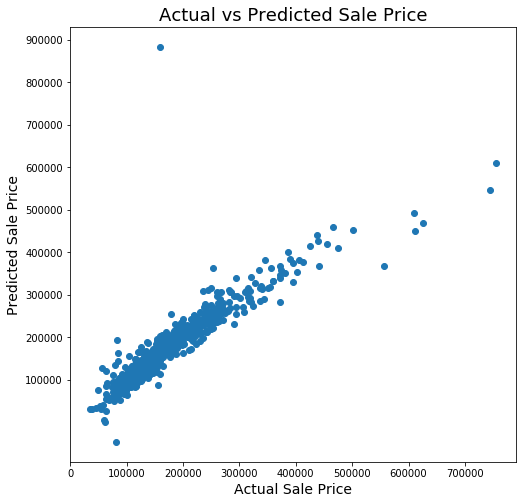

In [19]:
#Run transform_features() to clean dataset
transformed_df = transform_features(housing_data)

#Run select_features() to perform feature selection
filtered_df = select_features(transformed_df, 0.4, 10)

#Train and test KNN model
values, rmse = train_and_test(filtered_df, k = 4)

print("length",len(filtered_df))

In [20]:
print("=================================================")
print("Average RMSE Value:",int(rmse))

Average RMSE Value: 28447


# Conclusion
Linear regression was used to predict the sale price of houses in Ames, Iowa, USA. 

The operations to perform before training a linear regression model were first tested by dropping/filling missing data, dropping columns that would not be valuable to the model, performing feature engineering to produce new, meaningful columns and dropping columns that would reveal the final sale price of the house.

The linear regression model was then developed using K-Fold cross validation to estimate the skill of the model.

The cleaned dataset of 2927 rows was split into training and testing sets with the training set containing 1460 rows and the testing set containing the remainder.

The actual vs predicted sale price are shown in the chart below for a linear regression model using 4-fold cross validation 

<img src = "results.jpg">

The scatter plot above shows strongly linear results which indicate that the model accurately predicts the sale price of houses in Ames using the selected features. The average RMSE value for this model was 28 447.